# Motivation

假設你的公司研發出一款新泡麵產品，在公司裡面做了多次煮泡麵測試，其數據如下，

| 煮麵員 | 烹煮時間 | 試吃員 | 評價 |
| :----:| :----: | :----: | :----: |
| 小美 | 5 | 小呆 | 難吃 |
| 小美 | 10 | 小美 | 好吃 |
| 小華 | 7 | 小呆 | 可以吃 |
| 小華 | 15 | 小美 | 太糊 |
| 小呆 | 8 | 小萌 | 可以吃 |
| 小呆 | 13 | 小美 | 可以吃 |

做完實驗以後公司要求你撰寫一份說明書，去給可愛的客戶看，大家都知道一般客戶是沒什麼概念的，你應該建議客戶要煮多久時間的泡麵呢? <br>
大家都知道客戶在煮麵的時候可能會有很多干擾，像是跑出去接電話，也可能肚子太餓等不及，所以你覺得要怎麼建議你的客戶煮麵時間他才會滿意，是7分鐘? 還是13分鐘?




# Support vector machine （SVM）

Support vector machine 中文叫 "支持向量機"，不管是中文或英文都太長太難唸了，所以我以下都會簡稱 ```SVM```，我們現在先來定位一下 SVM ，SVM 是監督學習的方法，可以用來做分類（classification），回歸（regression），也可以用來做 新奇發現。





## novelty detection

他的叫法有很多種， anomaly detection, novelty detection, outliers detection，因為deep learning的興起，所以也有人用 GAN [GANomaly 2018](https://arxiv.org/pdf/1805.06725v3.pdf) 來做這件事，實做的部分可以參考 [anomalib](https://github.com/openvinotoolkit/anomalib)，不過講這麼多都不是今天的重點，我們現在是在教ML的SVM，所以要提一下 OneClassSVM 也可以用來達成這一件事。 <br>

我們另外還要提一件事，就是要說明研究這個問題的動機是什麼，動機1 是他可以幫忙發現新的類別，動機2 是他可以做異常偵測，去排除那些想要故意搗亂的人。



## pros and cons 優點和缺點

SVM 的優點有
- 在高維空間裡也很有效
- 對於數據維度遠高於數據樣本量的情況也有效
- 內存需求很少(因為他的算法只會跟邊界值有關，其他不重要)
- 可以選不同核函數去處理不同的數據

SVM 的缺點有
- SVM 不直接提供機率估計
- 如果特徵（features）的數量遠大於樣本（samples）的數量，容易over-fitting，需要選擇適合的 kernel 函數 與 正規化的處理。




下面我們來談談 SVM 的想法，假設我們收集了兩群資料。

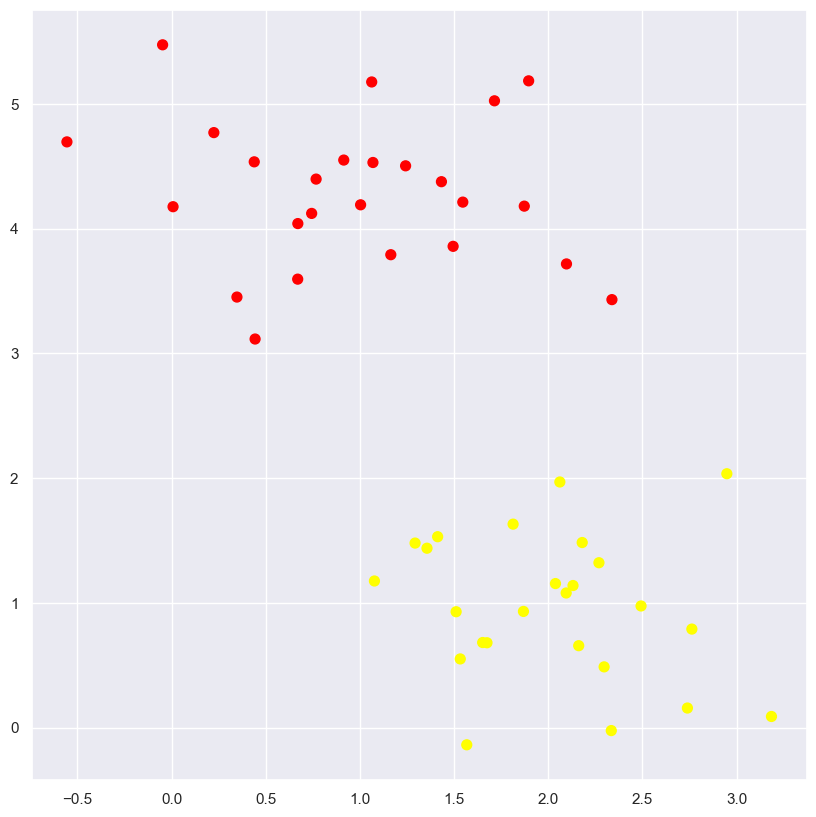

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [10, 10]

X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')


我們很自然地會想用直線去區分開來，但是問題來了，要用哪條直線?

(-1.0, 3.5)

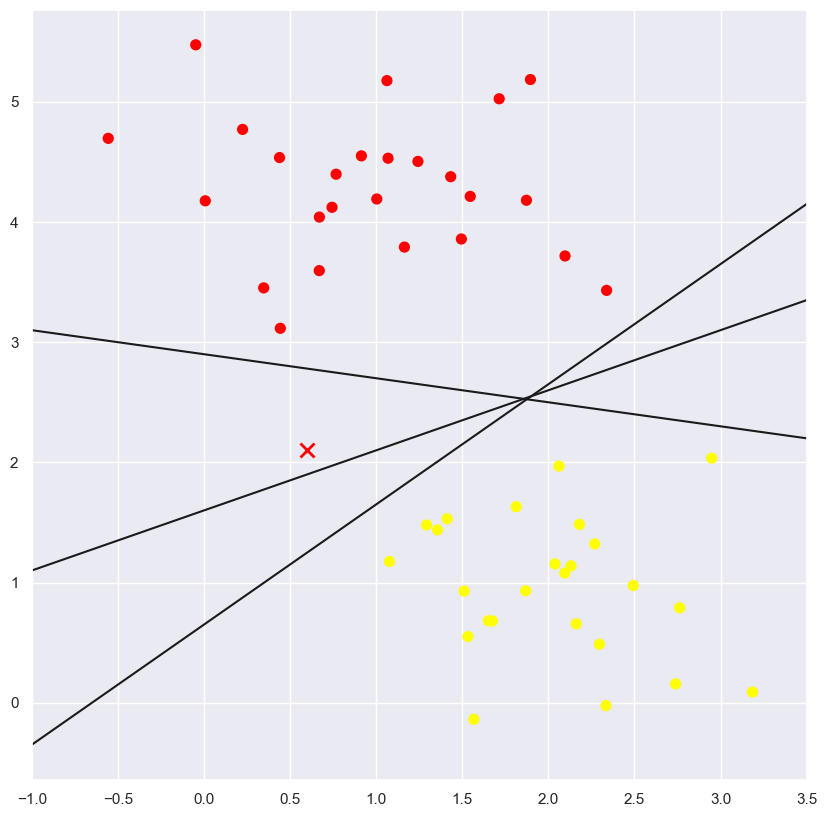

In [2]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

# 紅 X
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

# 三條分隔線
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)


假設紅色 X 是新來的資料，對於舊有資料上面的三條線，哪一條都可以完美的完成任務，但是對於新來的資料(紅 X)，三條線會有不同的看法，這時候 SVM 就跳出來說，我們需要嚴謹一點的方法來嚴肅對待這個問題。

## SVM: Maximizing the *Margin*
SVM 就跳出來說啦，我們選的分割線可以離他們的邊界越遠越好啊。



(-1.0, 3.5)

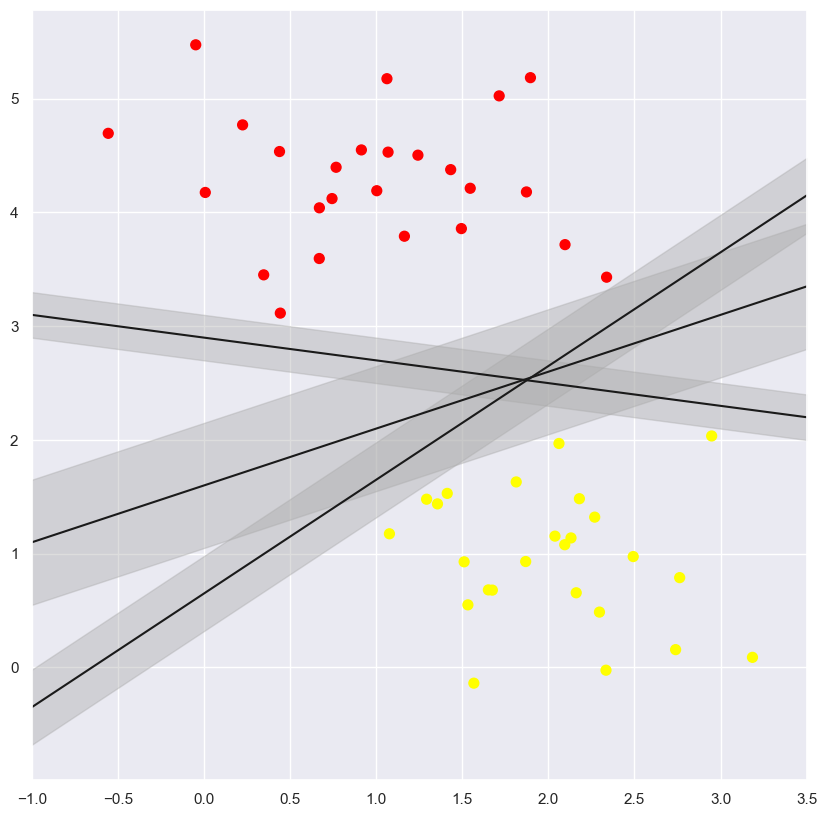

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

我們來看看邊界值

(-0.41872382476349596, 5.754870487889891)

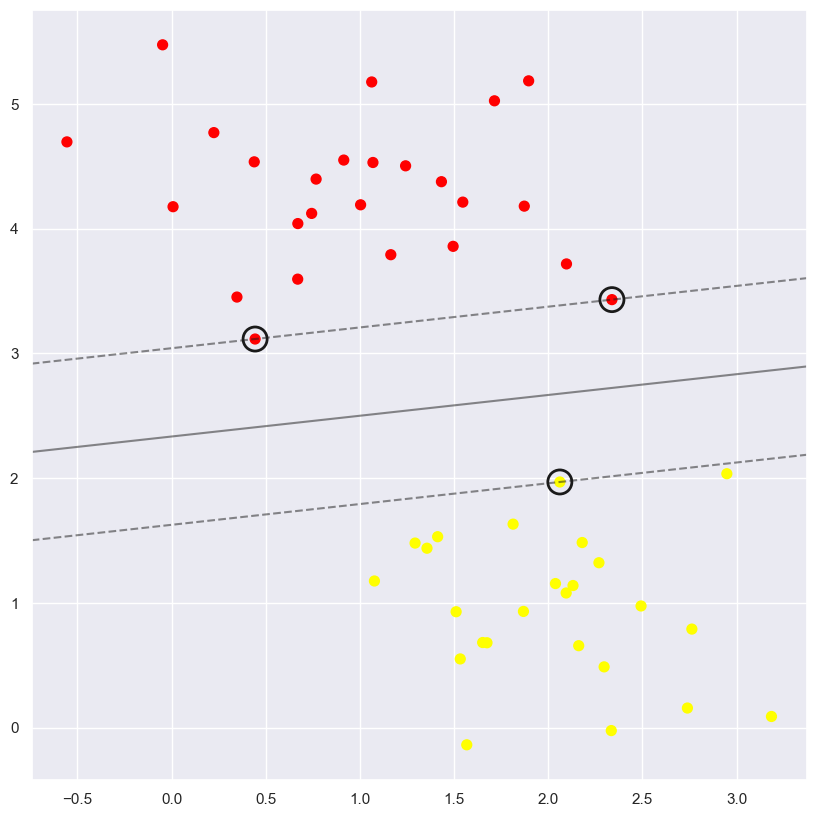

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

from scipy import stats
import seaborn as sns; sns.set()
from sklearn import datasets
from sklearn.svm import SVC # "Support vector classifier"

X, y = datasets.make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

classifier = SVC(kernel='linear', C=1E10)
classifier.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

axis = plt.gca()
xlim = axis.get_xlim()
ylim = axis.get_ylim()

# create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 30)
y = np.linspace(ylim[0], ylim[1], 30)
y_mg, x_mg = np.meshgrid(y, x)
xy = np.vstack([x_mg.ravel(), y_mg.ravel()]).T
P = classifier.decision_function(xy).reshape(x_mg.shape)

# plot decision boundary and margins
axis.contour(x_mg, y_mg, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

axis.scatter(classifier.support_vectors_[:, 0],
               classifier.support_vectors_[:, 1],
               s=300, linewidth=2, edgecolors='k', facecolors='none')


axis.set_xlim(xlim)
axis.set_ylim(ylim)


# support_vectors_

我們可以用 support_vectors_ 看到決策的邊界值。



In [5]:
# 這是他的邊界值

classifier.support_vectors_


array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

我們接下來要進入實戰環節，看 scikit learn 裡面提供哪些回歸 （regression）與分類 （classification）方法。

# Classification 

scikit learn 裡提供了 LinearSVC, NuSVC, SVC，我們下面直接看使用範例。



In [6]:
# LinearSVC 
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_features=4, random_state=87)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

classifier = LinearSVC(C=1, random_state=87, tol=1e-5)
classifier.fit(X_train, y_train)

print('Training accuracy: ', classifier.score(X_train, y_train))
print('Testing accuracy: ', classifier.score(X_test, y_test))

classifier.predict(X_test)


Training accuracy:  0.87375
Testing accuracy:  0.825


array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1])

In [7]:
# SVC
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_features=4, random_state=87)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
classifier = SVC(C=2, kernel='poly', random_state=87, tol=1e-5)
classifier.fit(X_train, y_train)

print('Training accuracy: ', classifier.score(X_train, y_train))
print('Testing accuracy: ', classifier.score(X_test, y_test))

classifier.predict(X_test)


Training accuracy:  0.8325
Testing accuracy:  0.795


array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1])

In [16]:
# NuSVC
from sklearn.svm import NuSVC
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_features=4, random_state=87)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
classifier = NuSVC(nu=0.7, kernel='poly', random_state=87, tol=1e-5)
classifier.fit(X_train, y_train)

print('Training accuracy: ', classifier.score(X_train, y_train))
print('Testing accuracy: ', classifier.score(X_test, y_test))

classifier.predict(X_test)


Training accuracy:  0.7925
Testing accuracy:  0.765


array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1])

# Regression

scikit learn 裡提供了 LinearSVR, NuSVR, SVR，我們下面直接看使用範例。


In [32]:
# LinearSVR 
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, y = make_regression(n_samples=1000, n_features=10, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regresser = LinearSVR(C=1, random_state=87, tol=1e-5)
regresser.fit(X_train, y_train)

y_pred = regresser.predict(X_test)

print("Mean squared error:", mean_squared_error(y_test, y_pred))



Mean squared error: 6.305698195443738e-24


6.305698195443738e-24

In [36]:
# SVR 
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, y = make_regression(n_samples=1000, n_features=10, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
regresser = SVR(kernel='rbf', C=1, tol=1e-5)
regresser.fit(X_train, y_train)

y_pred = regresser.predict(X_test)

print("Mean squared error:", mean_squared_error(y_test, y_pred))


Mean squared error: 12609.307074289563


In [38]:
# NuSVR 
from sklearn.svm import NuSVR
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, y = make_regression(n_samples=1000, n_features=10, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
regresser = NuSVR(kernel='linear', nu=0.7, tol=1e-5)
regresser.fit(X_train, y_train)

y_pred = regresser.predict(X_test)

print("Mean squared error:", mean_squared_error(y_test, y_pred))

Mean squared error: 1.2331531334160595e-12
